In [1]:
from pathlib import Path
import random
import os
from importlib import reload

import warnings
# Ignore PyTorch's KLDivLoss warning
warnings.simplefilter("ignore", category=UserWarning, lineno=2949)

import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
from tqdm.auto import tqdm

In [2]:
import utils.config
reload(utils.config)
import utils.data_handling
reload(utils.data_handling)
from utils.config import BASE_PATH, SPEC_DIR, DEVICE
from utils.data_handling import metadata_df

class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

metadata = metadata_df("train")
display(metadata.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,eeg_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,data/eegs_npy/train_eegs/1628180742.npy,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,data/eegs_npy/train_eegs/1628180742.npy,0


In [3]:
DEVICE

'cuda'

In [11]:
import utils.data_handling
reload(utils.data_handling)
from utils.data_handling import EegDataset

valid_frac = 0.1
num_unique_spectrograms = metadata.spectrogram_id.unique().shape[0]
valid_num = round(valid_frac * num_unique_spectrograms)
print(f"{num_unique_spectrograms} unique spectrograms, using {valid_num} for validation set.")

rng = np.random.default_rng(seed=4)
valid_set = rng.choice(metadata.spectrogram_id.unique(), size=valid_num, replace=False)

metadata_train = metadata[~metadata.spectrogram_id.isin(valid_set)]
metadata_valid = metadata[metadata.spectrogram_id.isin(valid_set)]
print(f"{len(metadata_train)} training items, {len(metadata_valid)} validation items.")

train_dset = EegDataset(metadata_train, force_unique=True, preloaded=True, random_state=4)
valid_dset = EegDataset(metadata_valid, preloaded=True)
print(f"{len(train_dset)} training items, {len(valid_dset)} validation items.")

11138 unique spectrograms, using 1114 for validation set.
95346 training items, 11454 validation items.
15350 training items, 11454 validation items.


In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=32)
print(len(train_loader), len(valid_loader))

480 358


In [17]:
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

(torch.Size([32, 20, 10000]), torch.Size([32, 6]))

In [14]:
import utils.wavenet
reload(utils.wavenet)
import utils.wavenet as wavenet
from torch import nn
import torch.nn.functional as F

wavenet = wavenet.WaveNetDiscriminative(
    in_channels=20,
    hidden_channels=20,
    num_blocks=13,
    kernel_size=2,
    downsample=200,
    num_classes=6,
    dilation_schedule=wavenet.default_dilation_schedule(),
    bias=False,
)


wavenet.receptive_field

1031

In [15]:
from torchinfo import summary
batch = next(iter(train_loader))
summary(wavenet, input_data=batch[0].to(DEVICE), col_names=["input_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
WaveNetDiscriminative                    [32, 20, 10000]           [32, 6]                   --                        --
├─CausalConv1d: 1-1                      [32, 20, 10000]           [32, 20, 10000]           --                        --
│    └─Conv1d: 2-1                       [32, 20, 10001]           [32, 20, 10000]           800                       256,000,000
├─ResidualStack: 1-2                     [32, 20, 10000]           [32, 20, 10000]           --                        --
│    └─ModuleList: 2-2                   --                        --                        --                        --
│    │    └─ResidualBlock: 3-1           [32, 20, 10000]           [32, 20, 10000]           2,000                     640,000,000
│    │    └─ResidualBlock: 3-2           [32, 20, 10000]           [32, 20, 10000]           2,000                     64

In [21]:
wavenet(batch[0].to(DEVICE)).shape

torch.Size([32, 6])

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.07E-01


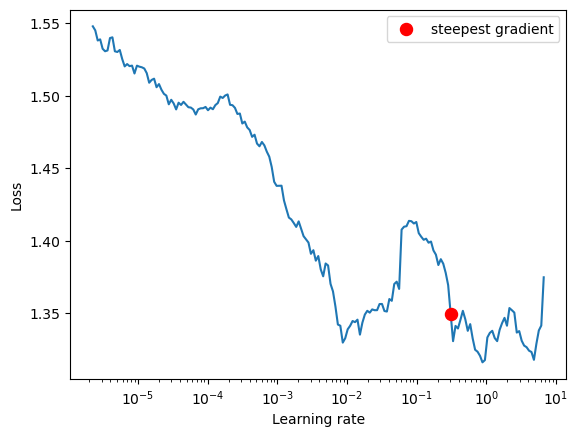

In [22]:
from torch_lr_finder import LRFinder

optimizer = torch.optim.AdamW(wavenet.parameters())
loss_fn = nn.KLDivLoss(reduction="batchmean")

finder = LRFinder(wavenet, optimizer, loss_fn)
finder.range_test(train_loader, start_lr=1e-6, end_lr=10, num_iter=200)
finder.plot()
finder.reset()

In [48]:
import utils.wavenet
reload(utils.wavenet)
from utils.logger import create_writer
from utils.config import MODEL_SAVE_DIR
from itertools import cycle

wavenet_gen = utils.wavenet.WaveNetDualTask(
    in_channels=20,
    hidden_channels=10,
    num_blocks=13,
    kernel_size=2,
    downsample=200,
    num_classes=6,
    gen_channels_out=20,
    dilation_schedule=utils.wavenet.default_dilation_schedule(),
    bias=False,
)

TRAIN_STEPS = 100_000
optimizer = torch.optim.AdamW(wavenet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-1, total_steps=TRAIN_STEPS)
gen_loss_fn = nn.MSELoss()
disc_loss_fn = nn.KLDivLoss(reduction="batchmean")
EVAL_PERIOD = 1000
EVAL_STEPS = 500
MODEL_NAME = "wavenet_disc_and_gen_10_channels_unique_eeg_id_one_cycle_scheduler"

total_batches = TRAIN_STEPS + ((TRAIN_STEPS // EVAL_PERIOD) * EVAL_STEPS)
pbar = tqdm(total=total_batches, desc="Training")

val_iterator = iter(cycle(valid_loader))

writer = create_writer(MODEL_NAME)

wavenet_gen.train()
histories = {'batches': [], 'train_gen_loss': [], 'train_disc_loss': [],
             'val_gen_loss': [], 'val_disc_loss': [], 'lr': []}
total_train_gen_loss = 0
total_train_disc_loss = 0
for i, (tens, targ) in enumerate(cycle(train_loader)):
    pbar.update()
    if i >= TRAIN_STEPS:
        break
    inputs, shifted = utils.wavenet.prep_batch_generative(tens)
    optimizer.zero_grad()
    gen_outputs, disc_outputs = wavenet_gen(inputs.to(DEVICE))
    gen_loss = gen_loss_fn(gen_outputs, shifted.to(DEVICE))
    disc_loss = disc_loss_fn(disc_outputs, targ.to(DEVICE))
    loss = gen_loss + disc_loss
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    total_train_gen_loss += gen_loss.item()
    total_train_disc_loss += disc_loss.item()
    if (i + 1) % EVAL_PERIOD == 0 or i + 1 == TRAIN_STEPS:
        # record number of batches and training metrics
        histories['batches'].append(i+1)
        histories['train_gen_loss'].append(total_train_gen_loss / EVAL_PERIOD)
        histories['train_disc_loss'].append(total_train_disc_loss / EVAL_PERIOD)
        total_train_gen_loss = 0
        total_train_disc_loss = 0

        # record learning rate
        histories['lr'].append(scheduler.get_last_lr()[0])

        # predict on validation data and record metrics
        wavenet_gen.eval()
        total_val_gen_loss = 0
        total_val_disc_loss = 0
        for j, (tens, targ) in enumerate(val_iterator):
            pbar.update()
            if j >= EVAL_STEPS:
                break
            inputs, shifted = utils.wavenet.prep_batch_generative(tens)
            with torch.inference_mode():
                gen_outputs, disc_outputs = wavenet_gen(inputs.to(DEVICE))
            gen_loss = gen_loss_fn(gen_outputs, shifted.to(DEVICE))
            disc_loss = disc_loss_fn(disc_outputs, targ.to(DEVICE))
            loss = gen_loss + disc_loss
            total_val_gen_loss += gen_loss.item()
            total_val_disc_loss += disc_loss.item()
        wavenet_gen.train()

        histories['val_gen_loss'].append(total_val_gen_loss / j)
        histories['val_disc_loss'].append(total_val_disc_loss / j)

        # If logging to TensorBoard, add metrics to writer
        writer.add_scalars(
            main_tag="Loss",
            tag_scalar_dict={
                "train_gen_loss": histories['train_gen_loss'][-1], 
                "val_gen_loss": histories['val_gen_loss'][-1], 
                "train_disc_loss": histories['train_disc_loss'][-1], 
                "val_disc_loss": histories['val_disc_loss'][-1], 
            }, 
            global_step=i+1)
        writer.add_scalar(
            "Learning rate",
            histories['lr'][-1], 
            global_step=i+1)
            # write to disk
        writer.flush()

        # If loss is NaN, the model died and we might as well stop training.
        if np.isnan(histories['val_disc_loss'][-1]) or np.isnan(histories['train_disc_loss'][-1]):
            print (f"Model died at training batch {i+1}, stopping training.")
            break
            
        torch.save(wavenet_gen.state_dict(), MODEL_SAVE_DIR / (MODEL_NAME + f"{i+1}_batches.pth"))
            

Training:   0%|          | 0/150000 [00:00<?, ?it/s]

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-04-07/wavenet_disc_and_gen_10_channels_unique_eeg_id_one_cycle_scheduler.


In [51]:
import utils.wavenet
wavenet_small = utils.wavenet.WaveNetDiscriminative(
    in_channels=20,
    hidden_channels=10,
    num_blocks=13,
    kernel_size=2,
    downsample=200,
    num_classes=6,
    dilation_schedule=utils.wavenet.default_dilation_schedule(),
    bias=False,
)
optimizer = torch.optim.AdamW
loss_fn = nn.KLDivLoss(reduction="batchmean")
scheduler = torch.optim.lr_scheduler.OneCycleLR
scheduler_kwargs = {"scheduler_max_lr": 1e-1, "scheduler_total_steps": 100_000}

trainer = Trainer(wavenet_small, train_loader, valid_loader,
                  optimizer=optimizer,
                  criterion=loss_fn,
                  lr=1e-3,
                  writer="auto",
                  model_name="wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler",
                  scheduler=scheduler,
                  scheduler_max_lr=1e-1,
                  scheduler_total_steps=100_000,
                 )

trainer.train_eval_loop(100_000, 1000, 500, save_period=10_000)

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-04-08/wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler.


Training:   0%|          | 0/171600 [00:00<?, ?it/s]

Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler_10000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler_20000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler_30000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler_40000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler_50000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_10_channels_unique_eeg_id_one_cycle_scheduler_60000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_10_channels_unique_eeg_id_on

In [53]:
wavenet = utils.wavenet.WaveNetDiscriminative(
    in_channels=20,
    hidden_channels=20,
    num_blocks=13,
    kernel_size=2,
    downsample=200,
    num_classes=6,
    dilation_schedule=utils.wavenet.default_dilation_schedule(),
    bias=False,
)

optimizer = torch.optim.AdamW
loss_fn = nn.KLDivLoss(reduction="batchmean")

trainer = Trainer(wavenet, train_loader, valid_loader,
                  optimizer=optimizer,
                  criterion=loss_fn,
                  lr=1e-2,
                  writer="auto",
                  model_name="wavenet_disc_only_20_channels_unique_eeg_id",
                 )

trainer.train_eval_loop(100_000, 1000, 500, save_period=10000)

trainer.plot_metrics()

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-04-08/wavenet_disc_only_20_channels_unique_eeg_id.


Training:   0%|          | 0/171600 [00:00<?, ?it/s]

Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_10000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_20000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_30000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_40000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_50000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_60000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_70000_batches.pt.


KeyboardInterrupt: 

In [ ]:
trainer = Trainer(wavenet, train_loader, valid_loader,
                  optimizer=optimizer,
                  criterion=loss_fn,
                  lr=1e-3,
                  writer="auto",
                  model_name="wavenet_disc_only_20_channels_unique_eeg_id_b",
                 )
trainer.train_eval_loop(100_000, 1000, 500, save_period=10000)

Created SummaryWriter saving to /home/pvk/Documents/python/ML/brains/logs/2024-04-08/wavenet_disc_only_20_channels_unique_eeg_id_b.


Training:   0%|          | 0/171600 [00:00<?, ?it/s]

Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_b_10000_batches.pt.
Saved a checkpoint at /home/pvk/Documents/python/ML/brains/models/wavenet_disc_only_20_channels_unique_eeg_id_b_20000_batches.pt.


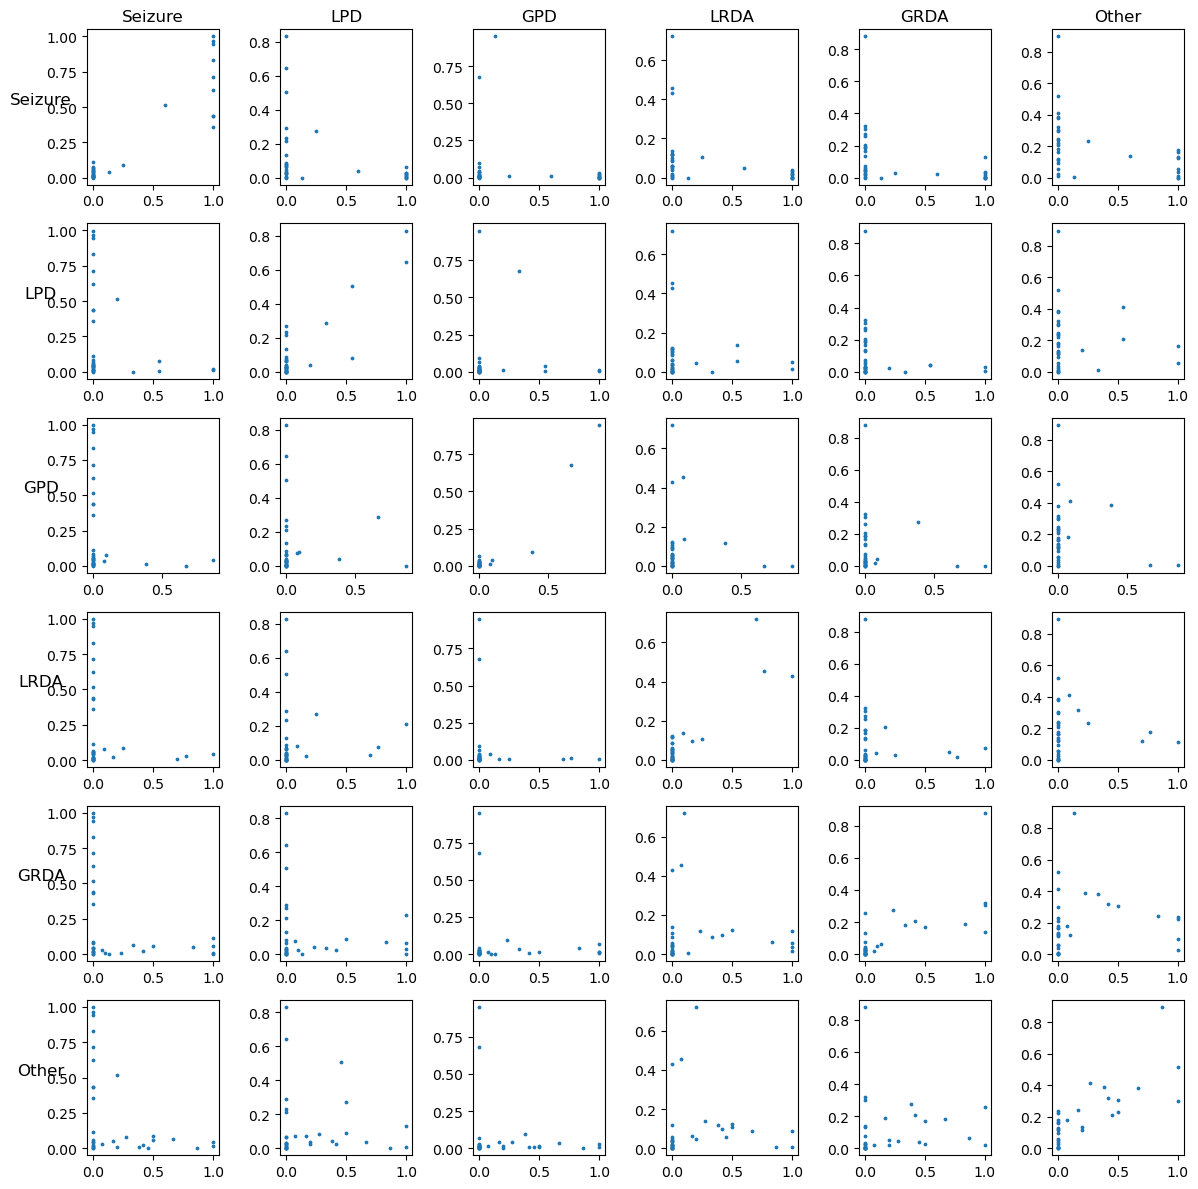

In [24]:
import utils.visualization
reload(utils.visualization)
from utils.visualization import scatterplot_matrix
batch = next(iter(train_loader))
wavenet.eval()
with torch.inference_mode():
    y_pred = wavenet(batch[0].to(DEVICE)).mean(dim=1).exp().cpu()
y_true = batch[1]

def scatterplot_matrix(y_true, y_pred,
                       labels=["Seizure", "LPD", "GPD", "LRDA", "GRDA", "Other"]):
    """Display a grid of scatterplots of residuals vs. actual values.
    
    This is intended for interpreting model behavior. Typically, y_true will be
    metadata_df[["Seizure", ..., "Other"]], and y_pred will be the predictions
    generated by a model on metadata_df.
    
    y_true: Arraylike of shape [n_items, n_labels], consisting of the true vote
      shares (which should probably be normalized to lie between 0 and 1).
    y_pred: Arraylike of shape [n_items, n_labels], consisting of a model's
      predictions on the same items as in y_true. Columns in y_true and y_pred
      should be in the same order.
    labels (optional): List of strings of length n_labels, consisting of labels
      to give to each row and column. The default behavior is all 6 labels in
      the order they appear in the competition metadata. One could also run
      this function with only a subset of these labels.
    """
    n_labels = len(labels)
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    assert y_true.shape[1] == n_labels
    assert y_pred.shape[1] == n_labels
    assert y_true.shape[0] == y_pred.shape[0]
    
    fig, axs = plt.subplots(n_labels, n_labels, figsize=(12,12))
    for i in range(n_labels):
        for j in range(n_labels):
            axs[i][j].scatter(y_true[:, i], y_pred[:, j], s=3)
    
    for ax, col in zip(axs[0], labels):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], labels):
        ax.set_ylabel(row, rotation=0, size='large')
    plt.tight_layout()

scatterplot_matrix(y_true, y_pred)
    

In [28]:
y_pred

tensor([[7.1384e-01, 1.2092e-02, 5.2319e-03, 1.2918e-02, 6.3605e-03, 5.7286e-02],
        [9.9969e-01, 3.8485e-06, 1.7158e-07, 2.4263e-05, 1.2996e-05, 1.2453e-05],
        [2.7978e-03, 2.3297e-03, 4.5742e-03, 3.7894e-02, 8.8028e-01, 2.4207e-02],
        [3.5808e-01, 2.6898e-02, 2.9283e-02, 3.5682e-02, 1.3170e-01, 1.7640e-01],
        [1.0961e-02, 6.5326e-02, 1.2111e-02, 1.1677e-01, 3.0300e-01, 2.3666e-01],
        [8.6478e-02, 2.7165e-01, 9.0481e-03, 1.0710e-01, 2.8231e-02, 2.3180e-01],
        [5.1749e-01, 3.8236e-02, 1.3686e-02, 4.6933e-02, 2.0580e-02, 1.3659e-01],
        [7.9017e-02, 8.2033e-02, 4.2018e-02, 1.3689e-01, 4.4879e-02, 4.1133e-01],
        [5.0719e-02, 6.9738e-02, 4.0912e-02, 6.0753e-02, 1.8898e-01, 2.4385e-01],
        [6.2321e-01, 2.8053e-02, 1.0943e-02, 2.3071e-02, 1.4899e-02, 1.2261e-01],
        [1.6231e-03, 2.8956e-01, 6.7826e-01, 9.9768e-05, 7.3012e-05, 8.4904e-03],
        [9.9249e-03, 4.2145e-02, 9.5784e-02, 1.1871e-01, 2.7319e-01, 3.8586e-01],
        [1.2695e